In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.random as jr
from jax.config import config
import seaborn as sns
from glob import glob 
import numpy as np 
import xarray as xr
from ensembles.plotters import _unique_legend

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

2022-07-15 13:43:10.115749: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Data Read

### Obs

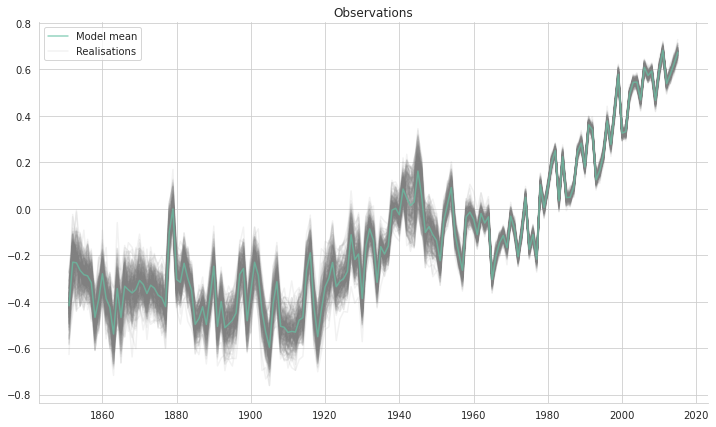

In [2]:
obs_da = xr.open_dataarray('data/obs/gmst/HadCRUT.5.0.1.0.analysis.anomalies_gmst.nc')
obs_time = obs_da.time
obs_da = obs_da.resample(time='Y').mean()
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()
sns.despine()

### Load all histroical and ssp370 forecasts

In [6]:
def load_model_data(ssp_dir='data/gmst/ssp370'):

    obs_da = xr.open_dataarray('data/obs/gmst/HadCRUT.5.0.1.0.analysis.anomalies_gmst.nc')
    obs_time = obs_da.time

    # Find the union between historical models and forecast models for this ssp
    hist_model_files = dict()
    for model_file in sorted(glob('data/gmst/historical/*nc')):
        model_name = '_'.join(model_file.split("/")[-1].split('_')[:2])
        hist_model_files[model_name] = model_file
    ssp_model_files = dict()
    for model_file in sorted(glob(ssp_dir + '/*nc')):
        model_name = '_'.join(model_file.split("/")[-1].split('_')[:2])
        ssp_model_files[model_name] = model_file
    model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
    hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}
    ssp_model_files = {k:ssp_model_files[k] for k in ssp_model_files if k in model_overlap}

    # Load historical modes and calculate the anomally, and climatology (for the forecast models)
    hist_anom_models = []
    climatology_dict = dict()
    for mn, mf in hist_model_files.items():
        # Read in model data into a ProcessModel datatype
        da = xr.open_dataarray(mf)
        # Use observational time for ease of comparison between models and obs
        da['time'] = obs_time
        # Put data into a ProcessModel class
        model_data = es.ProcessModel(da, mn)
        # Find the anomally of that data
        anomaly_model = model_data.calculate_anomaly(resample_freq='Y')
        hist_anom_models.append(anomaly_model)
        climatology_dict[mn] = anomaly_model.climatology

    hist_anom_models = es.ModelCollection(hist_anom_models)

    # Load forecast models and calculate the anomally
    ssp_anom_models = []
    for mn, mf in ssp_model_files.items():
        # Read in model data into a ProcessModel datatype
        da = xr.open_dataarray(mf)
        model_data = es.ProcessModel(da, mn)
        # Find the anomally of that data
        anomaly_model = model_data.calculate_anomaly(climatology=climatology_dict[mn], resample_freq='Y')
        ssp_anom_models.append(anomaly_model)

    ssp_anom_models = es.ModelCollection(ssp_anom_models)
    print(ssp_dir)
    print(hist_anom_models.number_of_models)
    print(np.sum([m.n_realisations for m in hist_anom_models]))
    print(np.sum([m.n_realisations for m in ssp_anom_models]))


    return hist_anom_models, ssp_anom_models

In [7]:
hist119_anom_models, ssp119_anom_models = load_model_data(ssp_dir='data/gmst/ssp119')
hist126_anom_models, ssp126_anom_models = load_model_data(ssp_dir='data/gmst/ssp126')
hist245_anom_models, ssp245_anom_models = load_model_data(ssp_dir='data/gmst/ssp245')
hist370_anom_models, ssp370_anom_models = load_model_data(ssp_dir='data/gmst/ssp370')
hist434_anom_models, ssp434_anom_models = load_model_data(ssp_dir='data/gmst/ssp434')
hist460_anom_models, ssp460_anom_models = load_model_data(ssp_dir='data/gmst/ssp460')
hist585_anom_models, ssp585_anom_models = load_model_data(ssp_dir='data/gmst/ssp585')


data/gmst/ssp119
6
95
69
data/gmst/ssp126
11
160
113
data/gmst/ssp245
16
183
147
data/gmst/ssp370
12
156
117
data/gmst/ssp434
3
50
15
data/gmst/ssp460
3
44
14
data/gmst/ssp585
14
172
115


In [7]:
realisations = np.vstack([hist119_anom_models[i].model_data.values for i in range(hist119_anom_models.number_of_models)])


In [8]:
realisations.shape

(95, 165)

### Construct model posteriors for all the data (both forecast and hindcast)

In [5]:
print('hist119')
hist119_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp119')
ssp119_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist126')
hist126_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp126')
ssp126_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist245')
hist245_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp245')
ssp245_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist370')
hist370_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp370')
ssp370_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist434')
hist434_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp434')
ssp434_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist460')
hist460_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp460')
ssp460_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('hist585')
hist585_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)
print('ssp585')
ssp585_anom_models.fit(model=es.GPDTW1D(), compile_objective=True, n_optim_nits=10, progress_bar=False)

hist119


/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/tslearn/barycenters/dba.py:735: ConvergenceWarning: DBA loss is increasing while it should not be. Stopping optimization.
  warnings.warn("DBA loss is increasing while it should not be. "
2022-07-14 12:55:18.123543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-14 12:55:18.123572: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-14 12:55:18.195008: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


ssp119
hist126
ssp126
hist245
ssp245
hist370
ssp370
hist434
ssp434
hist460
ssp460
hist585
ssp585


Plot some model posteriors to check they look sensible

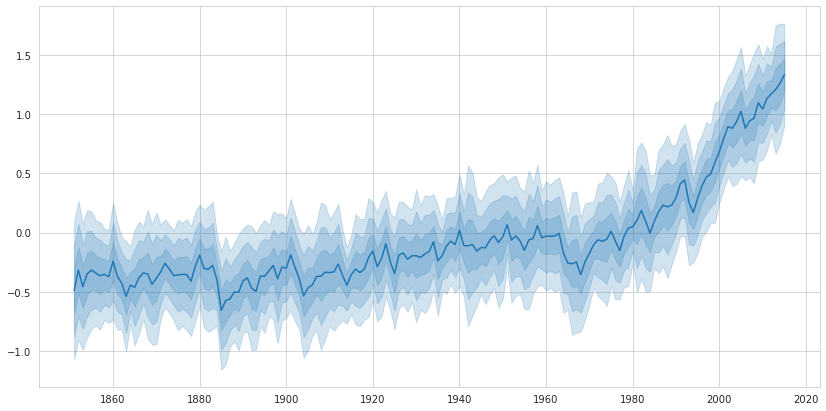

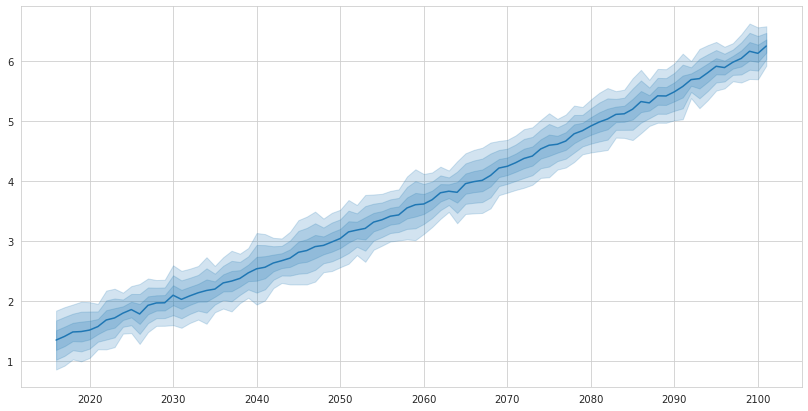

In [6]:
model_idx = 1
hist370_anom_models[model_idx].distribution.plot_temporally()
ssp370_anom_models[model_idx].distribution.plot_temporally()


### Weight the models (over the historic period) against observations

Calculate the loglikelihood weights for all historical runs

In [7]:
weight_function = es.LogLikelihoodWeight()
hist119_ll_weights = weight_function(hist119_anom_models, observations)
hist126_ll_weights = weight_function(hist126_anom_models, observations)
hist245_ll_weights = weight_function(hist245_anom_models, observations)
hist370_ll_weights = weight_function(hist370_anom_models, observations)
hist434_ll_weights = weight_function(hist434_anom_models, observations)
hist460_ll_weights = weight_function(hist460_anom_models, observations)
hist585_ll_weights = weight_function(hist585_anom_models, observations)

100%|██████████| 200/200 [00:00<00:00, 294.23it/s]


In [8]:
# 1 weight per model
weights_119 = hist119_ll_weights.mean('time').expand_dims(time=ssp119_anom_models[0].model_data.time, axis=1)
weights_126 = hist126_ll_weights.mean('time').expand_dims(time=ssp126_anom_models[0].model_data.time, axis=1)
weights_245 = hist245_ll_weights.mean('time').expand_dims(time=ssp245_anom_models[0].model_data.time, axis=1)
weights_370 = hist370_ll_weights.mean('time').expand_dims(time=ssp370_anom_models[0].model_data.time, axis=1)
weights_434 = hist434_ll_weights.mean('time').expand_dims(time=ssp434_anom_models[0].model_data.time, axis=1)
weights_460 = hist460_ll_weights.mean('time').expand_dims(time=ssp460_anom_models[0].model_data.time, axis=1)
weights_585 = hist585_ll_weights.mean('time').expand_dims(time=ssp585_anom_models[0].model_data.time, axis=1)

In [9]:
ensemble_method = es.Barycentre()
ssp119_barycentre = ensemble_method(ssp119_anom_models, weights_119)
ssp126_barycentre = ensemble_method(ssp126_anom_models, weights_126)
ssp245_barycentre = ensemble_method(ssp245_anom_models, weights_245)
ssp370_barycentre = ensemble_method(ssp370_anom_models, weights_370)
ssp434_barycentre = ensemble_method(ssp434_anom_models, weights_434)
ssp460_barycentre = ensemble_method(ssp460_anom_models, weights_460)
ssp585_barycentre = ensemble_method(ssp585_anom_models, weights_585)

100%|██████████| 86/86 [00:01<00:00, 47.27it/s]


Plotting for this

In [37]:
from ensembles.plotters import cmap

from scipy import stats
def plot_dist(dist, color='tab:blue', label='None', alpha=0.2, order=3):
    plt.plot(dist.mean.time, dist.mean, color=color, label=label, zorder=order)
    plt.fill_between(dist.mean.time.values, dist.mean - 2 * np.sqrt(dist.variance), dist.mean + 2 * np.sqrt(dist.variance), alpha=alpha, color=color, zorder=order-1, linewidth=0)

    return    

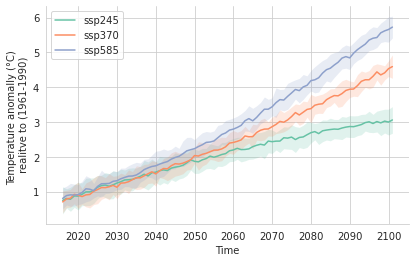

In [39]:
plt.rcParams['pdf.fonttype'] = 'truetype'

plt.figure(figsize=(6.5, 4))

labels = ['ssp245', 'ssp370', 'ssp585']
for i, forecast in enumerate([ssp245_barycentre, ssp370_barycentre, ssp585_barycentre]):

    plot_dist(forecast, color=cmap()[i], label=labels[i])

plt.xlabel('Time')
plt.ylabel('Temperature anomally (°C) \n realitve to (1961-1990)')

plt.legend()

sns.despine()
plt.savefig("figures/figure1_with_95percent_credible_interval.pdf")

plt.show()


Get values for 2050

In [53]:
upper = round((ssp119_barycentre.mean + 2 * np.sqrt(ssp119_barycentre.variance)).values[35], 3)
mean = round(ssp119_barycentre.mean.values[35], 3)
lower = round((ssp119_barycentre.mean - 2 * np.sqrt(ssp119_barycentre.variance)).values[35], 3)
print(f'ssp119 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp119_barycentre.mean + 2 * np.sqrt(ssp119_barycentre.variance)).values[85], 3)
mean = round(ssp119_barycentre.mean.values[85], 3)
lower = round((ssp119_barycentre.mean - 2 * np.sqrt(ssp119_barycentre.variance)).values[85], 3)
print(f'ssp119 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp126_barycentre.mean + 2 * np.sqrt(ssp126_barycentre.variance)).values[35], 3)
mean = round(ssp126_barycentre.mean.values[35], 3)
lower = round((ssp126_barycentre.mean - 2 * np.sqrt(ssp126_barycentre.variance)).values[35], 3)
print(f'ssp126 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp126_barycentre.mean + 2 * np.sqrt(ssp126_barycentre.variance)).values[85], 3)
mean = round(ssp126_barycentre.mean.values[85], 3)
lower = round((ssp126_barycentre.mean - 2 * np.sqrt(ssp126_barycentre.variance)).values[85], 3)
print(f'ssp126 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp245_barycentre.mean + 2 * np.sqrt(ssp245_barycentre.variance)).values[35], 3)
mean = round(ssp245_barycentre.mean.values[35], 3)
lower = round((ssp245_barycentre.mean - 2 * np.sqrt(ssp245_barycentre.variance)).values[35], 3)
print(f'ssp245 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp245_barycentre.mean + 2 * np.sqrt(ssp245_barycentre.variance)).values[85], 3)
mean = round(ssp245_barycentre.mean.values[85], 3)
lower = round((ssp245_barycentre.mean - 2 * np.sqrt(ssp245_barycentre.variance)).values[85], 3)
print(f'ssp245 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp370_barycentre.mean + 2 * np.sqrt(ssp370_barycentre.variance)).values[35], 3)
mean = round(ssp370_barycentre.mean.values[35], 3)
lower = round((ssp370_barycentre.mean - 2 * np.sqrt(ssp370_barycentre.variance)).values[35], 3)
print(f'ssp370 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp370_barycentre.mean + 2 * np.sqrt(ssp370_barycentre.variance)).values[85], 3)
mean = round(ssp370_barycentre.mean.values[85], 3)
lower = round((ssp370_barycentre.mean - 2 * np.sqrt(ssp370_barycentre.variance)).values[85], 3)
print(f'ssp370 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp434_barycentre.mean + 2 * np.sqrt(ssp434_barycentre.variance)).values[35], 3)
mean = round(ssp434_barycentre.mean.values[35], 3)
lower = round((ssp434_barycentre.mean - 2 * np.sqrt(ssp434_barycentre.variance)).values[35], 3)
print(f'ssp434 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp434_barycentre.mean + 2 * np.sqrt(ssp434_barycentre.variance)).values[85], 3)
mean = round(ssp434_barycentre.mean.values[85], 3)
lower = round((ssp434_barycentre.mean - 2 * np.sqrt(ssp434_barycentre.variance)).values[85], 3)
print(f'ssp434 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp460_barycentre.mean + 2 * np.sqrt(ssp460_barycentre.variance)).values[35], 3)
mean = round(ssp460_barycentre.mean.values[35], 3)
lower = round((ssp460_barycentre.mean - 2 * np.sqrt(ssp460_barycentre.variance)).values[35], 3)
print(f'ssp460 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp460_barycentre.mean + 2 * np.sqrt(ssp460_barycentre.variance)).values[85], 3)
mean = round(ssp460_barycentre.mean.values[85], 3)
lower = round((ssp460_barycentre.mean - 2 * np.sqrt(ssp460_barycentre.variance)).values[85], 3)
print(f'ssp460 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp585_barycentre.mean + 2 * np.sqrt(ssp585_barycentre.variance)).values[35], 3)
mean = round(ssp585_barycentre.mean.values[35], 3)
lower = round((ssp585_barycentre.mean - 2 * np.sqrt(ssp585_barycentre.variance)).values[35], 3)
print(f'ssp585 mean at 2050: {mean} ({lower}-{upper}) 95% credible interval')

upper = round((ssp585_barycentre.mean + 2 * np.sqrt(ssp585_barycentre.variance)).values[85], 3)
mean = round(ssp585_barycentre.mean.values[85], 3)
lower = round((ssp585_barycentre.mean - 2 * np.sqrt(ssp585_barycentre.variance)).values[85], 3)
print(f'ssp585 mean at 2100: {mean} ({lower}-{upper}) 95% credible interval')

ssp119 mean at 2050: 1.568 (1.191-1.945) 95% credible interval
ssp119 mean at 2100: 1.596 (1.22-1.972) 95% credible interval
ssp126 mean at 2050: 1.694 (1.321-2.066) 95% credible interval
ssp126 mean at 2100: 1.914 (1.544-2.284) 95% credible interval
ssp245 mean at 2050: 1.853 (1.522-2.184) 95% credible interval
ssp245 mean at 2100: 3.057 (2.675-3.439) 95% credible interval
ssp370 mean at 2050: 2.021 (1.611-2.43) 95% credible interval
ssp370 mean at 2100: 4.591 (4.256-4.927) 95% credible interval
ssp434 mean at 2050: 1.906 (1.716-2.095) 95% credible interval
ssp434 mean at 2100: 2.664 (2.446-2.883) 95% credible interval
ssp460 mean at 2050: 1.79 (1.413-2.167) 95% credible interval
ssp460 mean at 2100: 3.711 (3.467-3.954) 95% credible interval
ssp585 mean at 2050: 2.293 (1.989-2.597) 95% credible interval
ssp585 mean at 2100: 5.727 (5.415-6.039) 95% credible interval


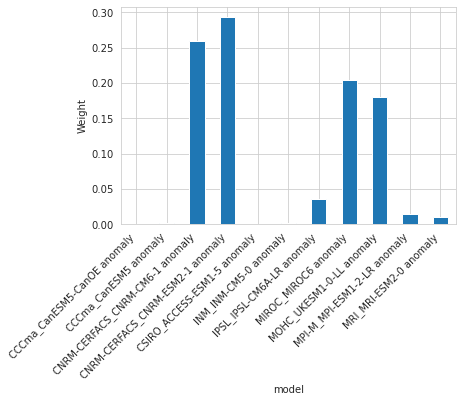

In [38]:
flat_weights = weights_single.mean('time').to_series()
flat_weights.plot.bar()
plt.ylabel('Weight')
plt.xticks(rotation=45, ha='right')
plt.show()

### Ensemble all this information (weights and model posteriors)

In [40]:
ensemble_method = es.Barycentre()
ssp370_barycentre = ensemble_method(ssp370_anom_models, weights_single)

100%|██████████| 86/86 [00:01<00:00, 52.48it/s]


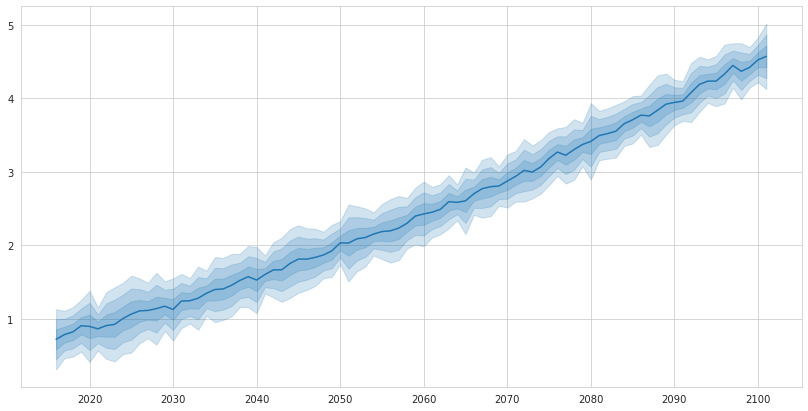

In [42]:
ssp370_barycentre.plot_temporally()

Create uniform weights for all historical runs

In [8]:
weight_function = es.UniformWeight()
hist245_mmm_weights = weight_function(hist245_anom_models, observations)
hist370_mmm_weights = weight_function(hist370_anom_models, observations)
ssp245_mmm_weights = weight_function(ssp245_anom_models, observations)
ssp370_mmm_weights = weight_function(ssp370_anom_models, observations)

Collapse ll weights to one-weight-per-model for future projections. (This should be functionalised at some point)

In [9]:
ssp245_ll_weights = hist245_ll_weights.mean('time').expand_dims(time=ssp245_anom_models[0].model_data.time, axis=1)
ssp370_ll_weights = hist370_ll_weights.mean('time').expand_dims(time=ssp370_anom_models[0].model_data.time, axis=1)

Construct the barycentres

In [10]:
ensemble_method = es.Barycentre()

hist245_barycentre = ensemble_method(hist245_anom_models, hist245_ll_weights)
ssp245_barycentre = ensemble_method(ssp245_anom_models, ssp245_ll_weights)

hist370_barycentre = ensemble_method(hist370_anom_models, hist370_ll_weights)
ssp370_barycentre = ensemble_method(ssp370_anom_models, ssp370_ll_weights)

100%|██████████| 86/86 [00:00<00:00, 103.49it/s]


Construct the Multimodel mean comparison

In [80]:
ensemble_method = es.MultiModelMean()

hist245_mmm = ensemble_method(hist245_anom_models, hist245_ll_weights)
ssp245_mmm = ensemble_method(ssp245_anom_models, ssp245_ll_weights)

hist370_mmm = ensemble_method(hist370_anom_models, hist370_ll_weights)
ssp370_mmm = ensemble_method(ssp370_anom_models, ssp370_ll_weights)

Plotting

In [106]:
from scipy import stats
def plot_dist(dist, color='tab:blue', label='None', axes=None, plot_dist=True, alpha=0.2, order=0):
    assert not isinstance(axes, list), 'Need to specify axis'
    axes[0].plot(dist.mean.time, dist.mean, color=color, label=label, zorder=order)
    axes[0].fill_between(dist.mean.time.values, dist.mean - 2 * np.sqrt(dist.variance), dist.mean + 2 * np.sqrt(dist.variance), alpha=alpha, color=color, zorder=order-1, linewidth=0)

    if plot_dist == True:
        x = np.linspace(1,4,500)
        y = stats.norm(dist.mean[35], np.sqrt(dist.variance[35])).pdf(x)
        axes[1].fill_between(y, [0] * len(x), x, alpha=0.2, color=color, linewidth=0)
        axes[1].plot(y, x, color=color)

    return    

Plot for poster

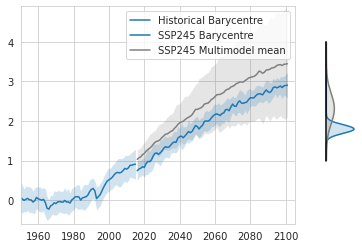

In [107]:
plt.rcParams['pdf.fonttype'] = 'truetype'
fig, axes = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios': [9, 1]})

plot_dist(hist245_barycentre, color='tab:blue', label='Historical Barycentre', axes=axes, plot_dist=False, order=2)
# plot_dist(hist370_barycentre, color='tab:blue', label='Historical Barycentre', axes=axes, plot_dist=False)


plot_dist(ssp245_barycentre, color='tab:blue', label='SSP245 Barycentre', axes=axes, order=8)
# plot_dist(ssp370_barycentre, color='tab:orange', label='SSP370 Barycentre', axes=axes, alpha=0.3)

plot_dist(ssp245_mmm, color='tab:grey', label='SSP245 Multimodel mean', axes=axes, order=5)
# plot_dist(ssp370_mmm, color='tab:grey', label='SSP370 Multimodel mean', axes=axes)



axes[0].set_xlim([-365.25 * 20, 365.25 * 135])
axes[1].set_ylim([-0.6, 4.9])

axes[1].plot([0, 0], [1, 4], 'k-', lw=1.5)
axes[1].set_axis_off()
axes[1].set_ylabel('Temperature at 2050 (°C)')

axes[0].legend()
fig.savefig("figure1_poster.pdf", bbox_inches='tight', transparent=True)

plt.show()

In [52]:
ax = axes[0]

In [ ]:
ax.set

NameError: name 'x' is not defined

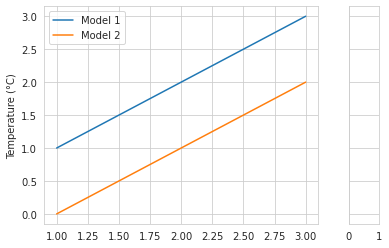

In [32]:
fig, axes = plt.subplots(ncols=2, sharey=True, gridspec_kw={'width_ratios': [9, 1]})
axes[0].plot([1,2,3], [1,2,3], label='Model 1')
axes[0].plot([1,2,3], [0,1,2], label='Model 2')

axes[0].set_ylabel('Temperature (°C)')
axes[0].legend()

axes[1].plot([0] * len(x), x, 'k-', lw=2)

axes[1].fill_between(y1, [0] * len(x), x, alpha=0.2)
axes[1].plot(y1, x)

axes[1].fill_between(y2, [0] * len(x), x, alpha=0.2)
axes[1].plot(y2, x)

axes[1].axis('off')
axes[1].set_ylabel('Temperature at 2050 (°C)')

plt.show()

Plot this output

In [12]:
def plot_dist(dist, color='tab:blue', label='None'):

    plt.plot(dist.mean.time, dist.mean, color=color, label=label, zorder=2)
    plt.fill_between(dist.mean.time.values, dist.mean - 2 * np.sqrt(dist.variance), dist.mean + 2 * np.sqrt(dist.variance), alpha=0.2, color=color, zorder=0)

    return    

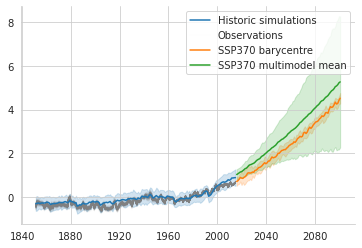

In [72]:
plt.rcParams['pdf.fonttype'] = 'truetype'


plt.figure()

plt.plot(observations.time, observations.model_data.T, alpha=0.01, color='gray', label='Observations', zorder=1)
plot_dist(hist370_barycentre, color='tab:blue', label='Historic simulations')

plot_dist(ssp370_barycentre, color='tab:orange', label='SSP370 barycentre')
plot_dist(ssp370_mmm, color='tab:green', label='SSP370 multimodel mean')
plt.legend()
ax = _unique_legend(plt.gca())

sns.despine()
plt.savefig("figure1_ssp370.pdf")

plt.show()


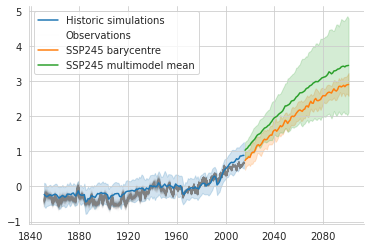

In [73]:
plt.rcParams['pdf.fonttype'] = 'truetype'


plt.figure()

plt.plot(observations.time, observations.model_data.T, alpha=0.01, color='gray', label='Observations', zorder=1)
plot_dist(hist245_barycentre, color='tab:blue', label='Historic simulations')

plot_dist(ssp245_barycentre, color='tab:orange', label='SSP245 barycentre')
plot_dist(ssp245_mmm, color='tab:green', label='SSP245 multimodel mean')
plt.legend()
ax = _unique_legend(plt.gca())

sns.despine()
plt.savefig("figure1_245.pdf")

plt.show()


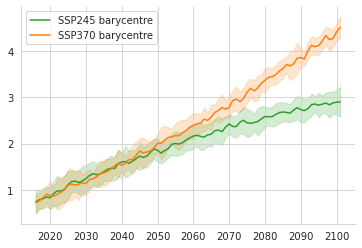

In [75]:
plt.rcParams['pdf.fonttype'] = 'truetype'


plt.figure()

# plt.plot(observations.time, observations.model_data.T, alpha=0.01, color='gray', label='Observations', zorder=1)
# plot_dist(hist370_barycentre, color='tab:blue', label='Historic simulations')
plot_dist(ssp245_barycentre, color='tab:green', label='SSP245 barycentre')

plot_dist(ssp370_barycentre, color='tab:orange', label='SSP370 barycentre')
# plot_dist(ssp370_mmm, color='tab:green', label='SSP370 multimodel mean')
plt.legend()
ax = _unique_legend(plt.gca())

sns.despine()
plt.savefig("figure1_poster.pdf")

plt.show()


In [29]:
print((ssp245_barycentre.mean + 2 * np.sqrt(ssp245_barycentre.variance))[35])
print((ssp245_barycentre.mean - 2 * np.sqrt(ssp245_barycentre.variance))[35])

<xarray.DataArray ()>
array(2.18593448)
Coordinates:
    time     datetime64[ns] 2050-12-31
<xarray.DataArray ()>
array(1.50943292)
Coordinates:
    time     datetime64[ns] 2050-12-31


In [30]:
print((ssp370_barycentre.mean + 2 * np.sqrt(ssp370_barycentre.variance))[35])
print((ssp370_barycentre.mean - 2 * np.sqrt(ssp370_barycentre.variance))[35])

<xarray.DataArray ()>
array(2.36256797)
Coordinates:
    time     datetime64[ns] 2050-12-31
<xarray.DataArray ()>
array(1.66152058)
Coordinates:
    time     datetime64[ns] 2050-12-31


In [31]:
print((ssp245_mmm.mean + 2 * np.sqrt(ssp245_mmm.variance))[35])
print((ssp245_mmm.mean - 2 * np.sqrt(ssp245_mmm.variance))[35])

<xarray.DataArray ()>
array(3.0648085)
Coordinates:
    time     datetime64[ns] 2050-12-31
<xarray.DataArray ()>
array(1.8029351)
Coordinates:
    time     datetime64[ns] 2050-12-31


In [32]:
print((ssp370_mmm.mean + 2 * np.sqrt(ssp370_mmm.variance))[35])
print((ssp370_mmm.mean - 2 * np.sqrt(ssp370_mmm.variance))[35])

<xarray.DataArray ()>
array(3.55991378)
Coordinates:
    time     datetime64[ns] 2050-12-31
<xarray.DataArray ()>
array(1.82413662)
Coordinates:
    time     datetime64[ns] 2050-12-31


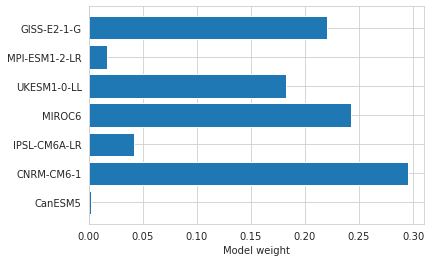

In [21]:
plt.rcParams['pdf.fonttype'] = 'truetype'

plt.figure()
labels = [name.split('_')[1].split(' ')[0] for name in x]
plt.barh(labels, y, align='center')
plt.xlabel('Model weight')
plt.savefig('weight_bar.pdf', transparent=True, bbox_inches = 'tight')
plt.show()